In [1]:
#====================================
# Author: Waleed M. Gondal
# Date: 22, December, 2016
#====================================
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
from cam_model import CAM
from utils import augment
from utils_nn import make_batches, count_images
import os
import matplotlib.pyplot as plt
import time
from IPython import display

#================================================
# Setting Hyper-Parameters 
#================================================
PRETRAINED_MODEL_PATH = None
N_EPOCHS = 200
INIT_LEARNING_RATE = 0.01
WEIGHT_DECAY_RATE = 0.0005
MOMENTUM = 0.9
IMAGE_HEIGHT  = 224
IMAGE_WIDTH   = 224
NUM_CHANNELS  = 3
BATCH_SIZE = 100
N_LABELS = 1000
DROPOUT = 0.75 
LOGS_PATH = './tensorflow_logs/'
WEIGHT_PATH = 'vgg16CAM.npy'
TRAINSET_PATH = '... test.csv'
VALSET_PATH ='... val.csv'
ckpt_dir = "./ckpt_dir"

# Make Batches from csv files
Make batches of images and their respective labels using standard tensorflow input pipeline

In [2]:
train_image_batch, train_label_batch = make_batches(TRAINSET_PATH, N_EPOCHS, 
                                                    IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE, training = True)
val_image_batch, val_label_batch = make_batches(VALSET_PATH, 1,
                                                IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE, training = False)

In [3]:
# Count the number of training and test examples
num_train = count_images(TRAINSET_PATH)
num_val = count_images(VALSET_PATH)
print ('Train_images: ', num_train)
print ('Validation_images: ', num_val)

Train_images:  10001
Validation_images:  10001


In [4]:
# Placeholders for tensorflow graph
learning_rate = tf.placeholder( tf.float32, [])
images_tf = tf.placeholder( tf.float32, [None, IMAGE_HEIGHT, IMAGE_WIDTH, 3], name="images")
labels_tf = tf.placeholder( tf.int64, [None], name='labels')  # the dimensions could be [None,N_CLASSES]

# Configure Network

In [5]:
cam = CAM(N_LABELS, WEIGHT_PATH)
conv6, output = cam.network(images_tf, is_training=True, dropout=DROPOUT)

# Define Loss 

In [6]:
with tf.name_scope('Loss'):
    loss_tf = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits( output, labels_tf ), name='loss_tf')
    weights_only = filter( lambda x: x.name.endswith('W:0'), tf.trainable_variables() )
    # L2 Regularization
    weight_decay = tf.reduce_sum(tf.pack([tf.nn.l2_loss(x) for x in weights_only])) * WEIGHT_DECAY_RATE
    loss_tf += weight_decay

# Define Optimization

In [7]:
train_op = tf.train.MomentumOptimizer(learning_rate, MOMENTUM).minimize(loss_tf)

In [8]:
# Training Accuracy per batch
with tf.name_scope('Accuracy'):
    correct_pred = tf.equal(tf.argmax(output, 1), labels_tf)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [9]:
# Saver Operation to save and restore all variables, first create directory
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
saver = tf.train.Saver() 

# Training
Training would go on for 200 epochs. It keeps updating the plots of loss and accuracy curves as the training proceeds.

Note: Tensorflow summaries are intentionally being avoided as they consume precious memory on GPU servers, thats why we are plotting on runtime bases.

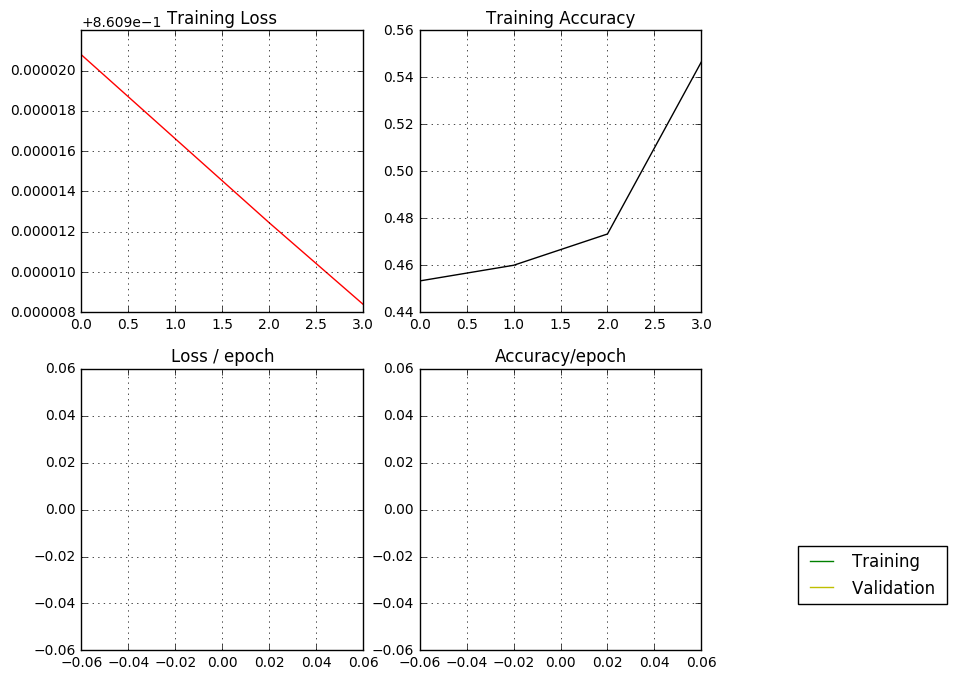

==============*TRAINING INFO*====================
Epoch 2 Iteration 20
Processed 600 / 135103
Accuracy in last 5 steps:  0.546667
Training Loss in last 5 steps: 0.860908


In [ ]:
init_op = tf.group(tf.initialize_all_variables(), tf.initialize_local_variables())
with tf.Session() as sess:
    sess.run(init_op)
    if PRETRAINED_MODEL_PATH:
        print "Using Pretrained model"        
        saver.restore(sess, PRETRAINED_MODEL_PATH)

    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    loss_list, accuracy_list, validation_list, validation_loss = [], [], [], []
    plot_loss, plot_accuracy, plot_validation, plot_validation_loss = [], [], [], []
    store_epoch_time = []
    epoch_train_loss, epoch_train_accuracy = [], []
    train_loss_list, train_acc_list = [], []
    
    g_loss_list, epoch_g_loss=[], []
    
    steps = 1
    batch_count = 1
    epoch = 0
    fig = plt.figure(figsize=(8,8))
    try:
        while not coord.should_stop() and epoch < N_EPOCHS:
            epoch+=1   
        
            train_correct = 0
            train_data = 0    
            epoch_start_time = time.time()            
        
            for i in range (int(num_train/BATCH_SIZE)):
                train_imbatch, train_labatch = sess.run([train_image_batch, train_label_batch])
                _, loss_val, off_acc= sess.run([train_op,loss_tf, accuracy], feed_dict={
                        learning_rate: INIT_LEARNING_RATE, images_tf: train_imbatch, labels_tf: train_labatch})
            
                loss_list.append(loss_val) 
                accuracy_list.append(off_acc)
                epoch_train_loss.append(loss_val)
                epoch_train_accuracy.append(off_acc)
                
                # Update Training plots and Print status after every 5 batches
                if (steps) % 5 == 0:   
                    plt.clf()
                    display.clear_output(wait=True)
                    accuracy_5steps = np.mean(accuracy_list)
                    loss_5steps = np.mean(loss_list)
                
                    plot_accuracy.append(accuracy_5steps)
                    plot_loss.append(loss_5steps)

                    
                    ax1 = fig.add_subplot(221)
                    ax1.plot(plot_loss,'r-')
                    ax1.grid(True)
                    ax1.set_title('Training Loss')
                    #ax1.axis('off')
                
                    ax2 = fig.add_subplot(222)
                    ax2.plot(plot_accuracy,'k-')
                    #ax2.legend(bbox_to_anchor=(1, 1.22))
                    ax2.grid(True)
                    ax2.set_title('Training Accuracy')
                    #ax2.axis('off')
                
                    ax3 = fig.add_subplot(223)
                    ax3.plot(train_loss_list,'g-', label='Training Loss')
                    ax3.plot(plot_validation_loss,'y-', label='Validation Loss')
                    #ax3.legend(bbox_to_anchor=(0.5, 0.1))
                    ax3.grid(True)
                    ax3.set_title('Loss / epoch')
                    #ax3.axis('off')
                
                    ax4 = fig.add_subplot(224)
                    ax4.plot(train_acc_list,'g-', label='Training ')
                    ax4.plot(plot_validation,'y-', label='Validation ')
                    ax4.legend(bbox_to_anchor=(1.9, 0.4))
                    ax4.grid(True)
                    ax4.set_title('Accuracy/epoch')
                    #ax4.axis('off')

                    plt.show()
                    #plt.pause(0.00001)
                    print "==============*TRAINING INFO*===================="
                    print "Epoch", epoch, "Iteration", steps
                    print "Processed", batch_count*BATCH_SIZE, '/', num_train
                    print 'Accuracy in last 5 steps: ', accuracy_5steps
                    print "Training Loss in last 5 steps:", loss_5steps
                    loss_list = []
                    accuracy_list = []
                    #summary_writer.add_summary(summary, steps)
                    
                steps += 1
                batch_count += 1
        
            train_loss_list.append(np.mean(epoch_train_loss))
            train_acc_list.append(np.mean(epoch_train_accuracy))
            epoch_train_loss, epoch_train_accuracy = [], []
        
            batch_count =1
            n_correct = 0
            n_data = 0
            epoch_time = (time.time() - epoch_start_time)/60.               
            print 'Time Elapsed for Epoch:'+str(epoch)+' is '+str (epoch_time) +' minutes'
            
            for i in range (int(num_val/BATCH_SIZE +1)):         
                val_imbatch, val_labatch = sess.run([val_image_batch, val_label_batch])
                val_accuracy, val_loss = sess.run([accuracy,loss_tf], feed_dict={images_tf:val_imbatch, labels_tf: val_labatch})
                validation_list.append(val_accuracy)
                validation_loss.append(val_loss)
            
            validation_accuracy = np.mean(validation_list)
            plot_validation.append(validation_accuracy)
            plot_validation_loss.append(np.mean(validation_loss))
            validation_list, validation_loss = [], []

            INIT_LEARNING_RATE *= 0.95
            if ((epoch) % 2 == 0 or validation_accuracy >=0.90):            
                saver.save(sess, ckpt_dir + "/grad_cam_model.ckpt", global_step=epoch)
            
            
    except tf.errors.OutOfRangeError:
        print('out of range')
    finally:      
        coord.request_stop()
        coord.join(threads)
        print('requesting, training stop')  
            
            
